<a href="https://colab.research.google.com/github/akemiyamashita/Trainable_Segmentation/blob/master/aug%2Btf_for_CEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
try:
  # %tensorflow_version は Colab にのみ存在します。
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil

In [0]:
SRC_DIR = '/content/gdrive/My Drive/医療情報ゼミ/for_ano/'

In [0]:
print(os.listdir(SRC_DIR))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']


In [0]:
print(len(os.listdir(SRC_DIR+'0')))

308


label : 0 is noisy image label. label: 12 is 'suture' images label
so we treat these images that label :0 is negative, 12 is positive.
negative images are 308.
positive images are 507.

# data migration

In [0]:
os.makedirs('/content/images', exist_ok =True)
os.makedirs('/content/images/train', exist_ok =True)
os.makedirs('/content/images/valid', exist_ok =True)
os.makedirs('/content/images/train/0', exist_ok =True)
os.makedirs('/content/images/valid/0', exist_ok =True)
os.makedirs('/content/images/train/1', exist_ok =True)
os.makedirs('/content/images/valid/1', exist_ok =True)

In [0]:
df = pd.read_csv('/content/ano - ano.csv')

In [0]:
df_0 = df[df['target']==0]
df_1 = df[df['target']==12]

In [0]:
from sklearn.model_selection import train_test_split

train0, valid0 = train_test_split(df_0, test_size=0.2)
train1, valid1 = train_test_split(df_1, test_size=0.2)

In [0]:
train1.shape

(405, 9)

In [0]:
d_dir = '/content/images/valid/0'

fn_list = valid0['path'].tolist()

for i in range(len(fn_list)):
  fn = fn_list[i]
  shutil.copy(fn, d_dir)

In [0]:
d_dir = '/content/images/valid/1'

fn_list = valid1['path'].tolist()

for i in range(len(fn_list)):
  fn = fn_list[i]
  shutil.copy(fn, d_dir)

In [0]:
d_dir = '/content/images/train/0'

fn_list = train0['path'].tolist()

for i in range(len(fn_list)):
  fn = fn_list[i]
  shutil.copy(fn, d_dir)

In [0]:
d_dir = '/content/images/train/1'

fn_list = train1['path'].tolist()

for i in range(len(fn_list)):
  fn = fn_list[i]
  shutil.copy(fn, d_dir)

In [0]:
PATH = '/content/images'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'valid')

In [17]:
print(train_dir)

/content/images/train


In [0]:
train_cats_dir = os.path.join(train_dir, '0')  # 学習用の0画像のディレクトリ
train_dogs_dir = os.path.join(train_dir, '1')  # 学習用の1画像のディレクトリ
validation_cats_dir = os.path.join(validation_dir, '0')  # 検証用の0画像のディレクトリ
validation_dogs_dir = os.path.join(validation_dir, '1')  # 検証用の1画像のディレクトリ

# data visualisation

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [20]:
print('total training 0 images:', num_cats_tr)
print('total training 1 images:', num_dogs_tr)

print('total validation 0 images:', num_cats_val)
print('total validation 1 images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training 0 images: 246
total training 1 images: 405
total validation 0 images: 62
total validation 1 images: 102
--
Total training images: 651
Total validation images: 164


In [0]:
batch_size = 128
epochs = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # 学習データのジェネレータ
validation_image_generator = ImageDataGenerator(rescale=1./255) # 検証データのジェネレータ

In [23]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 651 images belonging to 2 classes.


In [24]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 164 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen)

In [0]:
# この関数は、1行5列のグリッド形式で画像をプロットし、画像は各列に配置されます。
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

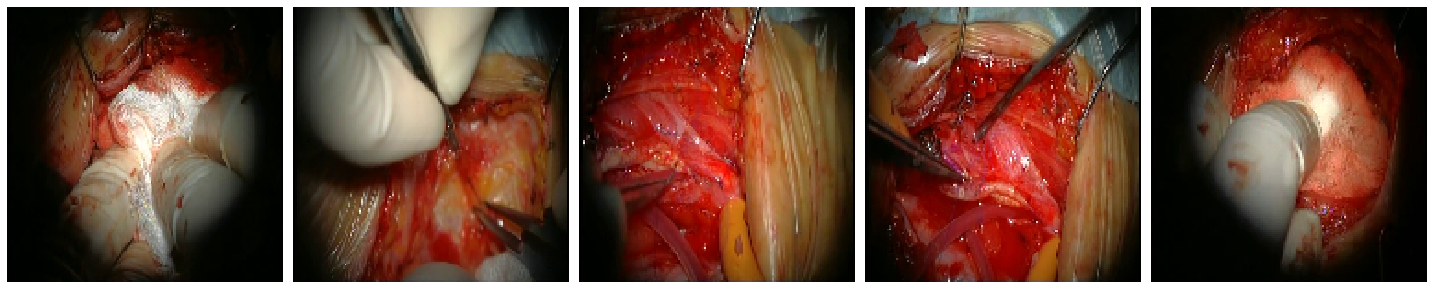

In [27]:
plotImages(sample_training_images[:5])

# model

In [0]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [31]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
5/5 [==============================] - 7s 1s/step - loss: 1.0237 - accuracy: 0.4570 - val_loss: 0.5524 - val_accuracy: 0.9375
Epoch 2/15
5/5 [==============================] - 4s 859ms/step - loss: 0.5076 - accuracy: 0.7170 - val_loss: 0.4126 - val_accuracy: 0.7500
Epoch 3/15
5/5 [==============================] - 5s 978ms/step - loss: 0.3697 - accuracy: 0.8750 - val_loss: 0.2342 - val_accuracy: 0.9531
Epoch 4/15
5/5 [==============================] - 4s 831ms/step - loss: 0.1881 - accuracy: 0.9159 - val_loss: 0.1754 - val_accuracy: 0.9375
Epoch 5/15
5/5 [==============================] - 3s 667ms/step - loss: 0.1788 - accuracy: 0.9310 - val_loss: 0.0901 - val_accuracy: 0.9531
Epoch 6/15
5/5 [==============================] - 5s 988ms/step - loss: 0.1243 - accuracy: 0.9500 - val_loss: 0.1097 - val_accuracy: 0.9688
Epoch 7/15
5/5 [==============================] - 4s 809ms/step - loss: 0.1371 - accuracy: 0.9273 - val_loss: 0.0973 - val_accuracy: 0.9531
Epoch 8/15
5/5 [=======

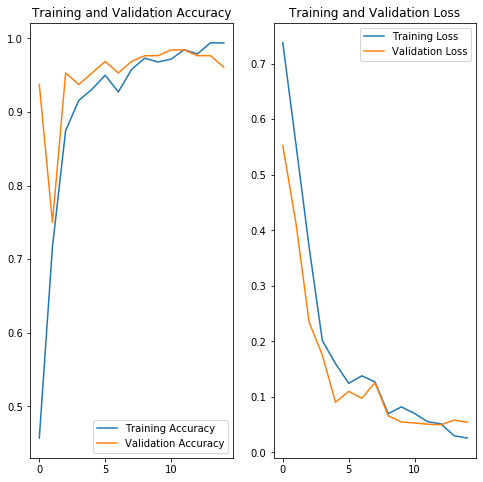

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# data augment

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [34]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 651 images belonging to 2 classes.


In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

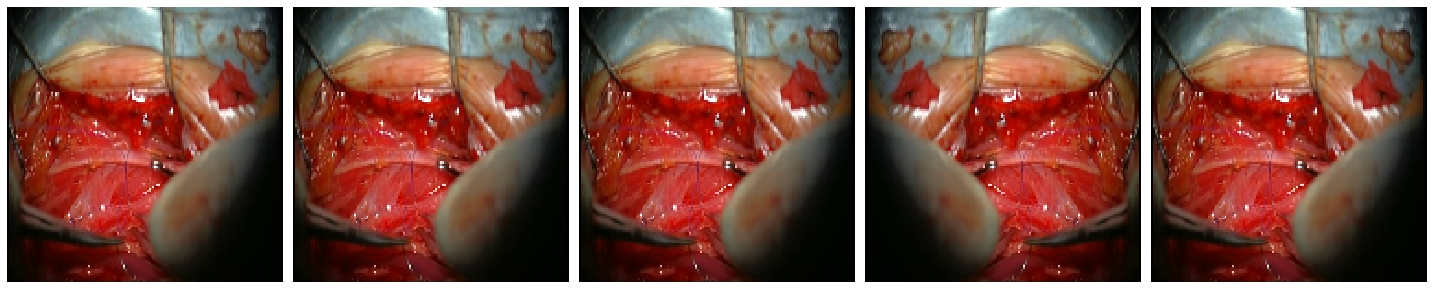

In [36]:
plotImages(augmented_images)

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [39]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 651 images belonging to 2 classes.


In [40]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 651 images belonging to 2 classes.


In [0]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [42]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 651 images belonging to 2 classes.


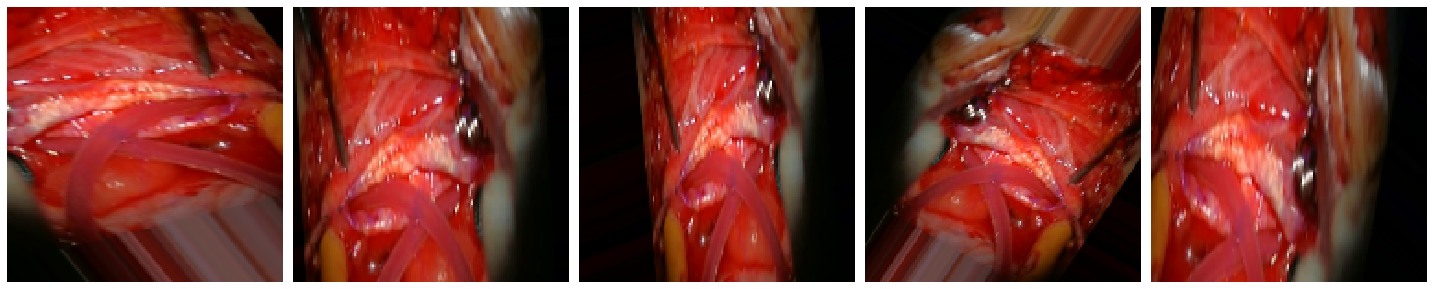

In [43]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [45]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 164 images belonging to 2 classes.


In [0]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [0]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

In [0]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

NameError: ignored